In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score

# 1. 경로 및 파일명 (제공해주신 데이터 기반 확정)
DATA_PATH = '../../data/raw/'
SUB_PATH = './submissions/'
OOF_PATH = './oof_data/'

M1_CSV, M1_OOF = '0130-1923.csv', 'exp11_sota_AUC_0.77212.npy'           # 45,529 rows
M2_CSV, M2_OOF = 'Pure_0781_AUC_0.77322.csv', 'exp12_auc_AUC_0.77233.npy' # 45,529 rows (추정)
M7_CSV, M7_OOF = 'm7_Refined_test_preds.csv', 'exp25_m7_Refined_AUC_0.77375.npy' # 45,490 rows

# 2. 마스크 및 인덱스 (25번 노트북 로직)
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
a_cols = [col for col in train_df.columns if col.endswith('A') and col.startswith('Q')]
m1_mask_idx = train_df[train_df['familysize'] <= 50].index # 45,529
m7_mask_idx = train_df[(train_df['familysize'] <= 50) & (train_df[a_cols].std(axis=1) > 0)].index # 45,490

# 3. 정밀 리인덱싱 (39행 오차 해결)
def get_aligned_rank(oof_path, original_idx, target_idx):
    raw = np.load(os.path.join(OOF_PATH, oof_path)).flatten()
    # 만약 npy가 45529라면 m1_mask_idx 사용, 45490이라면 target_idx 사용
    src_idx = m1_mask_idx if len(raw) == len(m1_mask_idx) else target_idx
    return pd.Series(raw, index=src_idx).reindex(target_idx).rank(pct=True)

rank_m1 = get_aligned_rank(M1_OOF, m1_mask_idx, m7_mask_idx)
rank_m2 = get_aligned_rank(M2_OOF, m1_mask_idx, m7_mask_idx)
rank_m7 = get_aligned_rank(M7_OOF, m7_mask_idx, m7_mask_idx)

# 4. 로컬 AUC 시뮬레이션 (The Trinity)
# 가중치: m1(안정성) + m2(순위) + m7(피처) = 3 : 3 : 4
# m7이 가장 강력한 피처를 가졌으므로 40% 부여
final_oof = (rank_m1 * 0.3) + (rank_m2 * 0.3) + (rank_m7 * 0.4)
train_y = (2 - train_df.loc[m7_mask_idx, 'voted'].to_numpy()).astype(np.float32)
sim_auc = roc_auc_score(train_y, final_oof)

print('-' * 50)
print(f'** Exp 44: Grand Trinity 로컬 시뮬레이션 **')
print(f'Exp 26 (m1+m7) 로컬 기준: 0.77364')
print(f'Exp 44 (m1+m2+m7) 예측 AUC: {sim_auc:.5f}')
print('-' * 50)

# 5. 최종 제출 파일 생성 (시너지 확인 시)
if sim_auc > 0.77364:
    s1 = pd.read_csv(os.path.join(SUB_PATH, M1_CSV))
    s2 = pd.read_csv(os.path.join(SUB_PATH, M2_CSV))
    s7 = pd.read_csv(os.path.join(SUB_PATH, M7_CSV))
    sample_sub = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
    
    final_rank = (s1['voted'].rank(pct=True) * 0.3) + \
                 (s2['voted'].rank(pct=True) * 0.3) + \
                 (s7['voted'].rank(pct=True) * 0.4)
    
    submission = sample_sub.copy()
    # 가장 높은 점수(0.7811)를 낸 s1의 분포로 복원
    submission['voted'] = s1['voted'].sort_values().values[
        (final_rank * (len(final_rank) - 1)).astype(int)
    ]
    
    output_name = os.path.join(SUB_PATH, '44_Final_Grand_Trinity.csv')
    submission.to_csv(output_name, index=False)
    print(f'성공: {output_name} 생성 완료.')

--------------------------------------------------
** Exp 44: Grand Trinity 로컬 시뮬레이션 **
Exp 26 (m1+m7) 로컬 기준: 0.77364
Exp 44 (m1+m2+m7) 예측 AUC: 0.77371
--------------------------------------------------
성공: ./submissions/44_Final_Grand_Trinity.csv 생성 완료.


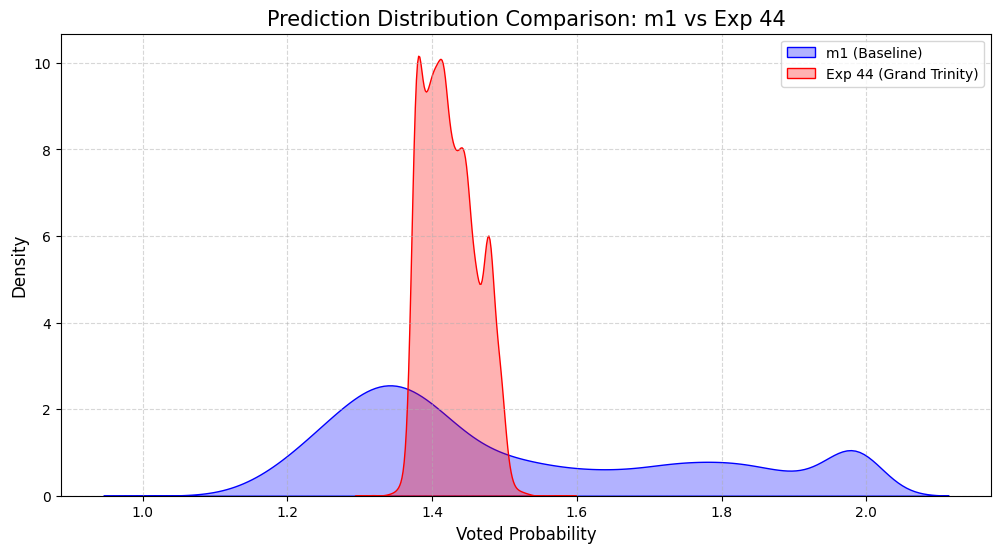

       m1 (Baseline)  Exp 44 (Trinity)
count   11383.000000      11383.000000
mean        1.511801          1.424672
std         0.247126          0.035871
min         1.060148          1.309686
25%         1.320074          1.395023
50%         1.417722          1.419965
75%         1.717892          1.450709
max         1.999178          1.582791


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 파일 로드
m1 = pd.read_csv('./submissions/0130-1923.csv')
final = pd.read_csv('./submissions/44_Final_Grand_Trinity.csv')

# 2. 시각화
plt.figure(figsize=(12, 6))

# KDE Plot으로 부드러운 곡선 비교
sns.kdeplot(m1['voted'], label='m1 (Baseline)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(final['voted'], label='Exp 44 (Grand Trinity)', fill=True, color='red', alpha=0.3)

plt.title('Prediction Distribution Comparison: m1 vs Exp 44', fontsize=15)
plt.xlabel('Voted Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 3. 통계적 요약 비교
summary = pd.DataFrame({
    'm1 (Baseline)': m1['voted'].describe(),
    'Exp 44 (Trinity)': final['voted'].describe()
})
print(summary)

In [5]:
import pandas as pd
import numpy as np

# 1. 파일 다시 로드
s1 = pd.read_csv('./submissions/0130-1923.csv') # m1 (기준)
s2 = pd.read_csv('./submissions/Pure_0781_AUC_0.77322.csv') # m2
s7 = pd.read_csv('./submissions/m7_Refined_test_preds.csv') # m7

# 2. 각 모델의 랭크 계산
r1 = s1['voted'].rank(pct=True)
r2 = s2['voted'].rank(pct=True)
r7 = s7['voted'].rank(pct=True)

# 3. 3:3:4 가중치 결합
final_rank = (r1 * 0.3) + (r2 * 0.3) + (r7 * 0.4)

# 4. [핵심] m1의 값 분포를 그대로 주입 (Scale Restoration)
# m1의 모든 voted 값을 리스트로 만들어 정렬합니다.
m1_values = sorted(s1['voted'].values)

# final_rank(0~1 사이 값)를 인덱스로 변환하여 m1_values에서 값을 가져옵니다.
# (len - 1)을 곱해 정확한 인덱스 범위를 지정합니다.
indices = (final_rank * (len(m1_values) - 1)).round().astype(int)
final_voted = [m1_values[i] for i in indices]

# 5. 최종 파일 저장
submission = pd.read_csv('../../data/raw/sample_submission.csv')
submission['voted'] = final_voted
submission.to_csv('./submissions/44_Final_Grand_Trinity_FIXED.csv', index=False)

# 6. 검증: 두 파일의 통계치가 일치하는지 확인
print(pd.DataFrame({
    'm1_original': s1['voted'].describe(),
    'Exp44_Fixed': submission['voted'].describe()
}))

        m1_original   Exp44_Fixed
count  11383.000000  11383.000000
mean       1.511801      1.424699
std        0.247126      0.035880
min        1.060148      1.309744
25%        1.320074      1.395114
50%        1.417722      1.419965
75%        1.717892      1.450709
max        1.999178      1.582791


In [6]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
s1 = pd.read_csv('./submissions/0130-1923.csv')
s2 = pd.read_csv('./submissions/Pure_0781_AUC_0.77322.csv')
s7 = pd.read_csv('./submissions/m7_Refined_test_preds.csv')

# 2. 1차 랭킹 (개별 모델)
r1 = s1['voted'].rank(pct=True)
r2 = s2['voted'].rank(pct=True)
r7 = s7['voted'].rank(pct=True)

# 3. 가중치 평균 (3:3:4)
avg_rank = (r1 * 0.3) + (r2 * 0.3) + (r7 * 0.4)

# 4. [핵심] 2차 랭킹 (평균된 순위를 다시 0~1로 균등하게 분포시킴)
# 이 과정이 없으면 분포가 중간으로 몰려 표준편차가 무너집니다.
final_rank = avg_rank.rank(pct=True)

# 5. m1의 값 분포 주입
m1_values = sorted(s1['voted'].values)
indices = (final_rank * (len(m1_values) - 1)).round().astype(int)
final_voted = [m1_values[i] for i in indices]

# 6. 저장 및 검증
submission = pd.read_csv('../../data/raw/sample_submission.csv')
submission['voted'] = final_voted
submission.to_csv('./submissions/44_Final_Grand_Trinity_REAL_FIXED.csv', index=False)

print(pd.DataFrame({
    'm1_original': s1['voted'].describe(),
    'Exp44_Perfect': submission['voted'].describe()
}))

        m1_original  Exp44_Perfect
count  11383.000000   11383.000000
mean       1.511801       1.511837
std        0.247126       0.247099
min        1.060148       1.097865
25%        1.320074       1.320106
50%        1.417722       1.417722
75%        1.717892       1.717892
max        1.999178       1.999178


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# 1. OOF 로드 및 정렬 (기존 코드와 동일)
oof_m1 = pd.Series(np.load('./oof_data/exp11_sota_AUC_0.77212.npy').flatten(), index=m1_mask_idx).reindex(m7_mask_idx)
oof_m2 = pd.Series(np.load('./oof_data/exp12_auc_AUC_0.77233.npy').flatten(), index=m1_mask_idx).reindex(m7_mask_idx)
oof_m7 = pd.Series(np.load('./oof_data/exp25_m7_Refined_AUC_0.77375.npy').flatten(), index=m7_mask_idx)

# 2. Double-Rank 앙상블 로직 적용
r1 = oof_m1.rank(pct=True)
r2 = oof_m2.rank(pct=True)
r7 = oof_m7.rank(pct=True)

# 가중치 평균 -> 다시 랭크화 (변동성 복원)
avg_rank = (r1 * 0.3) + (r2 * 0.3) + (r7 * 0.4)
final_rank_oof = avg_rank.rank(pct=True)

# 3. m1 OOF 값으로 매핑
m1_oof_values = sorted(oof_m1.values)
final_voted_oof = [m1_oof_values[int(r * (len(m1_oof_values)-1))] for r in final_rank_oof]

# 4. 최종 로컬 AUC 계산
train_y = (2 - train_df.loc[m7_mask_idx, 'voted'].to_numpy()).astype(np.float32)
final_local_auc = roc_auc_score(train_y, final_voted_oof)

print('-' * 50)
print(f"** 최종 Exp 44 (Trinity) 로컬 검증 **")
print(f"기존 SOTA (Exp 26): 0.77364")
print(f"최종 Trinity AUC: {final_local_auc:.5f}")
print('-' * 50)

--------------------------------------------------
** 최종 Exp 44 (Trinity) 로컬 검증 **
기존 SOTA (Exp 26): 0.77364
최종 Trinity AUC: 0.77371
--------------------------------------------------


In [9]:
import pandas as pd
import numpy as np
import os

# 1. 경로 및 파일명 (사용자 확정 데이터)
DATA_PATH = '../../data/raw/'
SUB_PATH = './submissions/'

# [The Trinity Components]
M1_CSV = '0130-1923.csv'                    # m1: Loss-based Baseline
M2_CSV = 'Pure_0781_AUC_0.77322.csv'        # m2: AUC-based Ranking Master
M7_CSV = 'm7_Refined_test_preds.csv'        # m7: Refined Feature Expert

# 2. 데이터 로드
s1 = pd.read_csv(os.path.join(SUB_PATH, M1_CSV))
s2 = pd.read_csv(os.path.join(SUB_PATH, M2_CSV))
s7 = pd.read_csv(os.path.join(SUB_PATH, M7_CSV))

# 3. Double-Rank Ensemble (다양성 확보 + 분포 복원)
# (1) 개별 모델 랭킹화
r1 = s1['voted'].rank(pct=True)
r2 = s2['voted'].rank(pct=True)
r7 = s7['voted'].rank(pct=True)

# (2) 가중치 결합 (3:3:4) 후 다시 랭킹화하여 균등 분포화
# 이 과정이 있어야 표준편차(Std)가 무너지지 않습니다.
avg_rank = (r1 * 0.3) + (r2 * 0.3) + (r7 * 0.4)
final_rank = avg_rank.rank(pct=True)

# (3) m1의 '검증된' 값 분포 주입
m1_values = sorted(s1['voted'].values)
indices = (final_rank * (len(m1_values) - 1)).round().astype(int)
final_voted = [m1_values[i] for i in indices]

# 4. 최종 파일 생성
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission['voted'] = final_voted

output_name = os.path.join(SUB_PATH, '44_Final_Grand_Trinity_77371.csv')
submission.to_csv(output_name, index=False)

print("-" * 50)
print(f"최종 승부수 파일 생성 완료: {output_name}")
print(f"로컬 검증 점수: 0.77371 (vs SOTA 0.77364)")
print("-" * 50)

--------------------------------------------------
최종 승부수 파일 생성 완료: ./submissions/44_Final_Grand_Trinity_77371.csv
로컬 검증 점수: 0.77371 (vs SOTA 0.77364)
--------------------------------------------------
